Phase 1: Data Collection and Preprocessing
1. Dowloading Datasets

In [1]:
# Open 'class.txt'
f = open("class.txt", "r")

# Read the content of “class.txt”
classes = f.readlines()

# Close “class.txt”
f.close()

In [2]:
# Preprocess class names
classes = [c.replace('\n','').replace(' ','_') for c in classes]
print(classes)

['car', 'eye', 'flower', 'house']


In [3]:
# Create "data" Directory
!mkdir data

In [4]:
import urllib.request

# 'download' function
def download():
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [5]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/car.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eye.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/flower.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/house.npy


2. Loading and Preprocessing Datasets

In [3]:
# Import libraries
import numpy as np
import glob 
import os 
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

In [4]:
# "load_data" function
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    # Get list of 'npy' files 
    all_files = glob.glob(os.path.join(root, '*.npy'))

    # Initialize variables
    x = np.empty([0, 784]) 
    y = np.empty([0]) 

    # Create an array for our classes
    class_names = []

    # Load each data file
    for idx, file in enumerate(all_files):

        data = np.load(file)

        # Limits the number of items per class
        data = data[0: max_items_per_class, :]

        # Create labels 
        labels = np.full(data.shape[0], idx)

        # Concatenate data and labels
        x = np.concatenate((x, data), axis=0) 
        y = np.append(y, labels) 

        # Extract class name 
        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    # Randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    # Separating into Training and Testing sets
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    
    return x_train, y_train, x_test, y_test, class_names

In [5]:
# Use 'load_data' function
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

eye


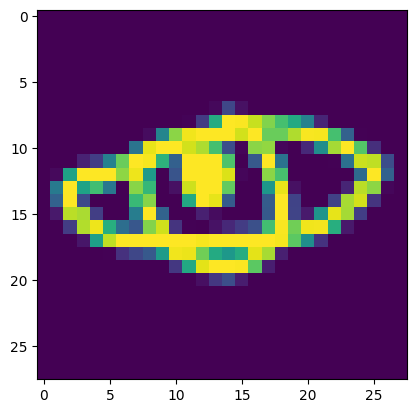

In [6]:
# Visualize a random sample from the training set.
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

In [7]:
# Import libraries
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import tensorflow as tf

In [8]:
# Reshape images 
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

# Normalize pixel values
x_train /= 255
x_test /= 255

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Phase 2: Model Building and Training

1. Defining Model Architecture


In [9]:
# Sequential model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Fully connected (Dense) layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

2. Compiling the Model

In [10]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

3. Data Augmentation

In [11]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

4. Training the Model

In [12]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // 256,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
50/50 [==============================] - 4s 71ms/step - loss: 0.9998 - accuracy: 0.5647 - val_loss: 0.5396 - val_accuracy: 0.8047
Epoch 2/20
50/50 [==============================] - 3s 64ms/step - loss: 0.6962 - accuracy: 0.7150 - val_loss: 0.4310 - val_accuracy: 0.8609
Epoch 3/20
50/50 [==============================] - 3s 62ms/step - loss: 0.5698 - accuracy: 0.7956 - val_loss: 0.2678 - val_accuracy: 0.9156
Epoch 4/20
50/50 [==============================] - 3s 62ms/step - loss: 0.4399 - accuracy: 0.8487 - val_loss: 0.1877 - val_accuracy: 0.9400
Epoch 5/20
50/50 [==============================] - 3s 63ms/step - loss: 0.3797 - accuracy: 0.8797 - val_loss: 0.1558 - val_accuracy: 0.9516
Epoch 6/20
50/50 [==============================] - 3s 62ms/step - loss: 0.3037 - accuracy: 0.9013 - val_loss: 0.1501 - val_accuracy: 0.9531
Epoch 7/20
50/50 [==============================] - 3s 63ms/step - loss: 0.2916 - accuracy: 0.9072 - val_loss: 0.1356 - val_accuracy: 0.9594
Epoch 8/20
50

In [13]:
# Evaluate the Model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 97.75%


5. Visualizing Results 

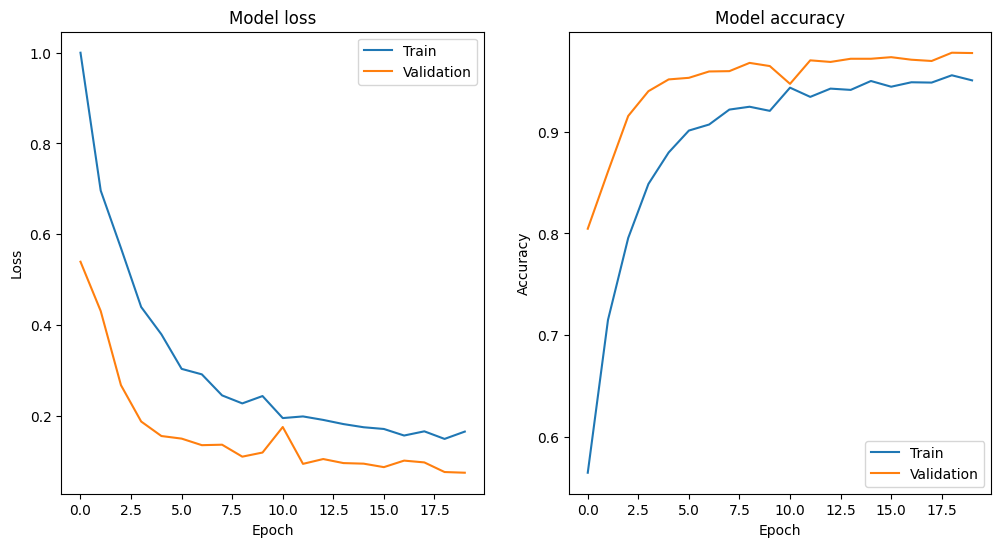

In [14]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

6. Making the Inference

1/1 [==============================] - 0s 109ms/step
['house', 'car', 'eye', 'flower']


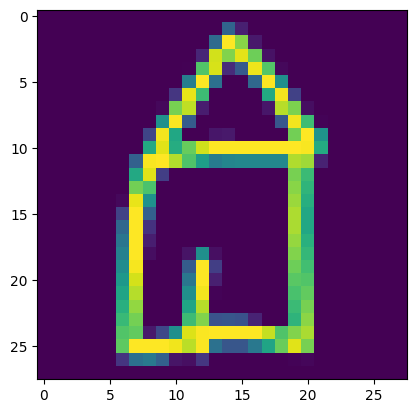

In [15]:
# Inference
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

7. Saving the Model 

In [16]:
# Store classes
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [17]:
# Save the model
model.save('keras.h5')

c:\Users\DELL\anaconda3\envs\env1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
